# Trabajo de Felipe

## Problema

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago
de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo
que aterrizó o despegó de SCL. Para cada vuelo se cuenta con la siguiente información:

* **Fecha-I** : Fecha y hora programada del vuelo.
* **Vlo-I** : Número de vuelo programado.
* **Ori-I** : Código de ciudad de origen programado.
* **Des-I** : Código de ciudad de destino programado.
* **Emp-I** : Código aerolínea de vuelo programado.
* **Fecha-O** : Fecha y hora de operación del vuelo.
* **Vlo-O** : Número de vuelo de operación del vuelo.
* **Ori-O** : Código de ciudad de origen de operación
* **Des-O** : Código de ciudad de destino de operación.
* **Emp-O** : Código aerolínea de vuelo operado.
* **DIA** : Día del mes de operación del vuelo.
* **MES** : Número de mes de operación del vuelo.
* **AÑO** : Año de operación del vuelo.
* **DIANOM** : Día de la semana de operación del vuelo.
* **TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional.
* **OPERA** : Nombre de aerolínea que opera.
* **SIGLAORI** : Nombre ciudad origen.
* **SIGLADES** : Nombre ciudad destino.

## Desarrollo

Para la mejora del modelo seleccionado (XGBoost with Upsampling) en primera instancia se realizaron los siguientes cambios:

* Se creo la libreria `utils.py`, la cual contiene las funciones que se utilizan en el notebook, para modularizar el código.
* Se corrige las funciones de `calcular_tasas` y `dif_minutos`, ya que la primera funcion el calculo de la tasa estaba al reves (se calculaba total vuelos/ total atrasados, en vez de total atrasados/total vuelos) y la segunda funcion no estaba calculando la diferencia en minutos correctamente para horarios especificos por lo que se añadieron 60 segundo a ciertos horarios para considerar todos los casos.
* Se crea un archivo `confing.yaml`, el cual contiene los parametros que se utilizan en el notebook, para que sea mas facil modificarlos y no tener que modificar el codigo.
* Se utiliza `pathlib` para utilizar paths relativos para mejorar la portabilidad del codigo.

### 0. Obtención de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import missingno as msng
import warnings
from pathlib import Path
import pickle
import yaml

warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
with open('config/config.yaml') as file:
    config = yaml.safe_load(file)

data_path=Path(config['data_directory'])

In [3]:
df = pd.read_csv(data_path/'raw'/config['data_name'])

In [4]:
df['temporada_alta'] = df['Fecha-I'].apply(utils.temporada_alta)
df['dif_min'] = df.apply(utils.dif_minutes, axis = 1)
df['atraso_15'] = np.where(df['dif_min'] > 15, 1, 0)
df['periodo_dia'] = df['Fecha-I'].apply(utils.get_periodo_dia)

In [5]:
df[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv(data_path/'processed'/'synthetic_features.csv', index = False)

In [6]:
tasas_destinos = utils.calcular_tasa(df, 'SIGLADES')
tasas_destinos

,Tasa (%)
Buenos Aires,26.0
Antofagasta,15.0
Lima,23.0
Calama,12.0
Puerto Montt,17.0
...,...
Quito,100.0
Washington,0.0
"Pisco, Peru",0.0
Puerto Stanley,100.0


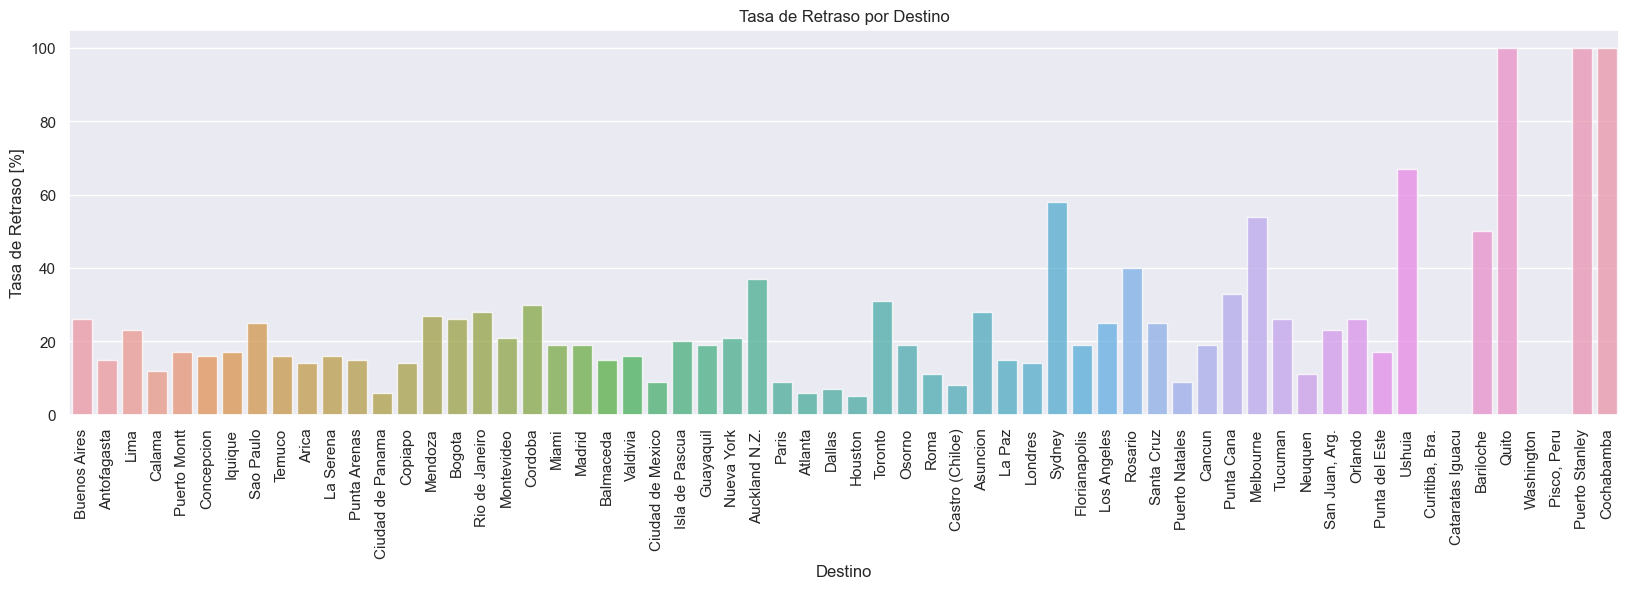

In [7]:
tasas_destinos_values = df['SIGLADES'].value_counts().index
plt.figure(figsize = (20,5))
sns.set(style="darkgrid")
sns.barplot(x=df['SIGLADES'].value_counts().index, y=tasas_destinos['Tasa (%)'], alpha = 0.75)
plt.title('Tasa de Retraso por Destino')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Destino', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [8]:
tasas_aerolineas = utils.calcular_tasa(df, 'OPERA')
tasas_aerolineas

,Tasa (%)
Grupo LATAM,18.0
Sky Airline,18.0
Aerolineas Argentinas,24.0
Copa Air,6.0
Latin American Wings,41.0
Avianca,27.0
JetSmart SPA,18.0
Gol Trans,36.0
American Airlines,7.0
Air Canada,46.0


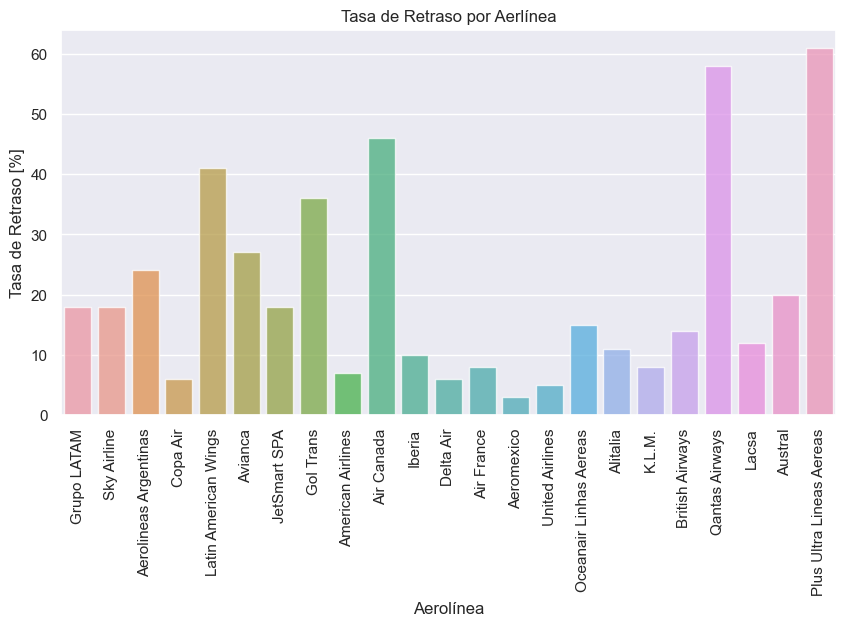

In [9]:
tasas_aerolineas_values = df['OPERA'].value_counts().index

plt.figure(figsize = (10,5))
sns.set(style="darkgrid")
sns.barplot(x=tasas_aerolineas_values, y=tasas_aerolineas['Tasa (%)'], alpha = 0.75)
plt.title('Tasa de Retraso por Aerlínea')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Aerolínea', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [10]:
tasas_meses = utils.calcular_tasa(df, 'MES')
tasas_meses

,Tasa (%)
12,25.0
1,16.0
11,20.0
10,23.0
7,29.0
8,17.0
9,17.0
2,15.0
3,12.0
5,16.0


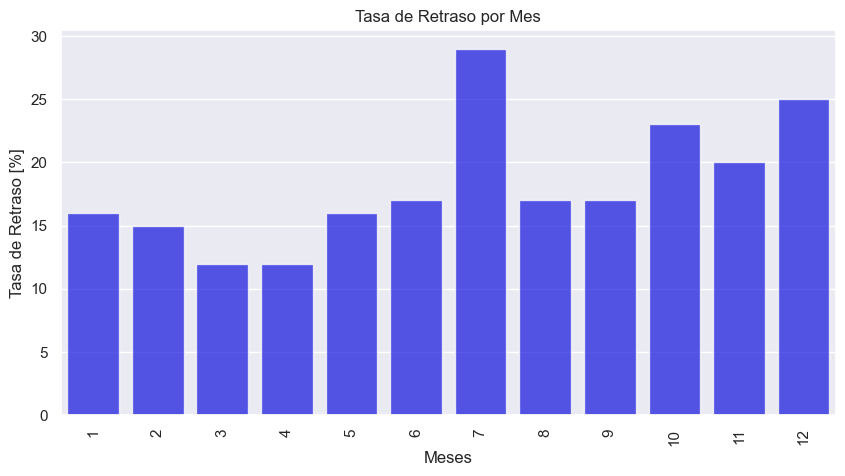

In [11]:
tasas_meses_values = df['MES'].value_counts().index

plt.figure(figsize = (10,5))
sns.set(style="darkgrid")
sns.barplot(x=tasas_meses_values, y=tasas_meses['Tasa (%)'], color = 'blue', alpha = 0.75)
plt.title('Tasa de Retraso por Mes')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Meses', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [12]:
tasas_dias = utils.calcular_tasa(df, 'DIANOM')
tasas_dias

,Tasa (%)
Viernes,22.0
Jueves,20.0
Lunes,20.0
Domingo,16.0
Miercoles,17.0
Martes,17.0
Sabado,16.0


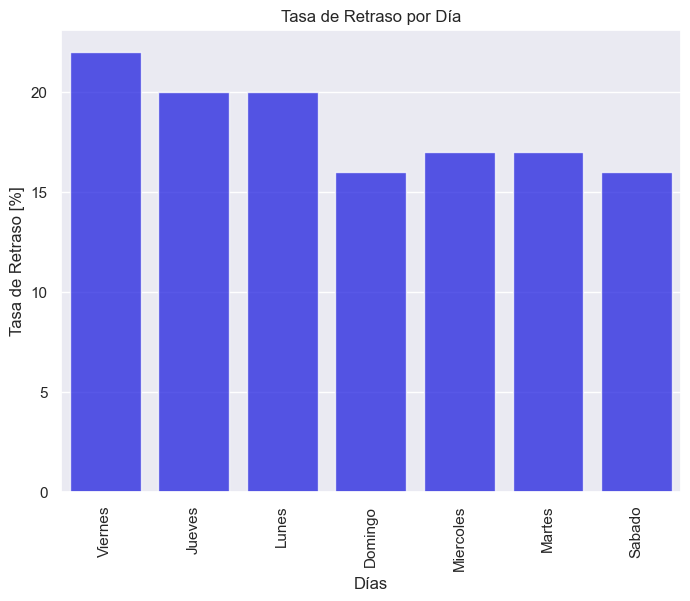

In [13]:
tasas_dias_values = df['DIANOM'].value_counts().index

sns.set(style="darkgrid")
plt.figure(figsize = (8,6))
sns.barplot(x=tasas_dias_values, y=tasas_dias['Tasa (%)'], color = 'blue', alpha = 0.75)
plt.title('Tasa de Retraso por Día')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Días', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [14]:
tasas_temporada = utils.calcular_tasa(df, 'temporada_alta')
tasas_temporada

,Tasa (%)
0,18.0
1,20.0


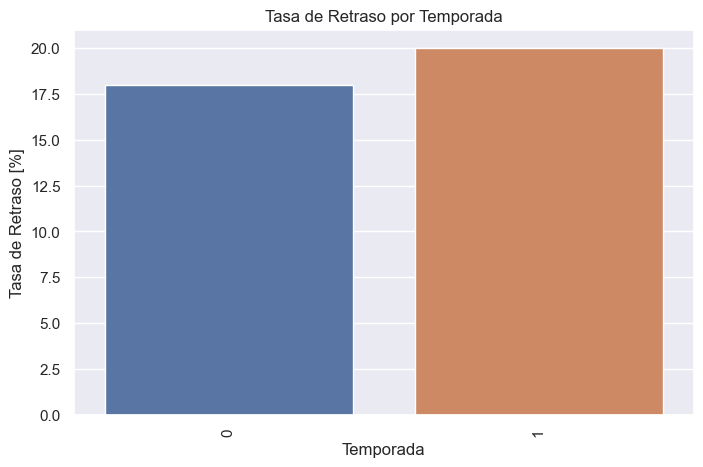

In [15]:
tasas_temporada_values = df['temporada_alta'].value_counts().index

plt.figure(figsize = (8, 5))
sns.set(style="darkgrid")
sns.barplot(x=tasas_temporada_values, y=tasas_temporada['Tasa (%)'])
plt.title('Tasa de Retraso por Temporada')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Temporada', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [16]:
tasas_tipovuelo = utils.calcular_tasa(df, 'TIPOVUELO')
tasas_tipovuelo

,Tasa (%)
N,15.0
I,23.0


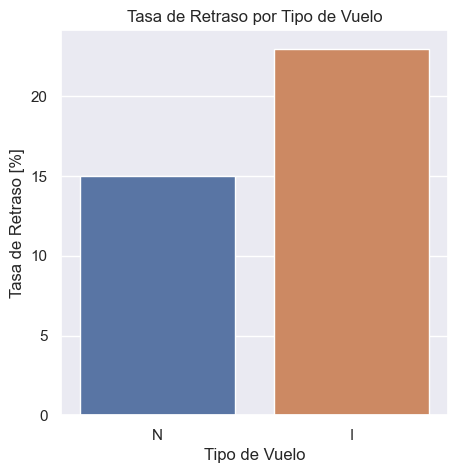

In [17]:
tasas_tipovuelo_values = df['TIPOVUELO'].value_counts().index

plt.figure(figsize = (5,5))
sns.set(style="darkgrid")
sns.barplot(x=tasas_tipovuelo_values, y=tasas_tipovuelo['Tasa (%)'])
plt.title('Tasa de Retraso por Tipo de Vuelo')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Tipo de Vuelo', fontsize=12)
plt.show()

In [18]:
tasa_periododia = utils.calcular_tasa(df, 'periodo_dia')
tasa_periododia

,Tasa (%)
tarde,20.0
mañana,16.0
noche,20.0


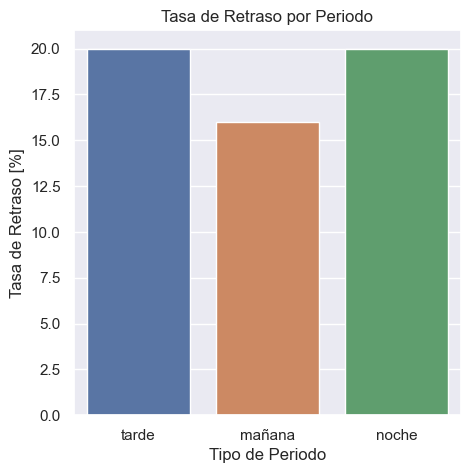

In [19]:
tasas_periodo_values = df['periodo_dia'].value_counts().index

plt.figure(figsize = (5,5))
sns.set(style="darkgrid")
sns.barplot(x=tasas_periodo_values, y=tasa_periododia['Tasa (%)'])
plt.title('Tasa de Retraso por Periodo')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Tipo de Periodo', fontsize=12)

plt.show()

* ¿Qué variables esperarías que más influyeran en predecir atrasos?

En esta sección va a cambiar las conclusiones ya que utiliza la funcion `calcular_tasas` de diferente manera, pero en general se puede ver que las variables que mas influyen en los atrasos son:
* **Aerolíneas**: Dependiendo de la calidad de gestión de cada aerolínea puede ser que afecte en sus programaciones. También puede que afecte el tipo de aerolínea, si es una low cost por ejemplo, estas llevan menos equipaje ya que es un costo extra para cada pasajero por lo que el tiempo de carga es menor, corriendo menor riesgo de retraso. 
* **Tipo de Vuelo**: esto puede afectar en cómo esté el clima del país de destino. Por ejemplo si se tiene que volar a argentina y se tiene que cruzar por la cordillera y hay un mal clima, es posible que se tenga que esperar un rato para poder salir.
* **Mes**: En el mes de julio se ve la mayor tasa de atrasos en comparación a los otros meses.  
 

### Para el modelo seleccionado (XGBoost with Upsampling) se mantiene el mismo preprocesamiento de datos que en el notebook original.

Como mejora se considerara tecnicas de grid search para encontrar los mejores hiperparametros para el modelo y cross validation para evaluar el modelo.


In [26]:
#Resample
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import xgboost as xgb

data = shuffle(df[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'atraso_15']], random_state = 111)
data_no_retraso = data[data['atraso_15'] == 0]
data_atraso = data[data['atraso_15'] == 1]

data_atraso_upsampled = resample(data_atraso, 
                                 replace = True,     # sample with replacement
                                 n_samples = 30000,    # to match majority class
                                 random_state = 42) # reproducible results

data_upsampled = pd.concat([data_no_retraso, data_atraso_upsampled])

In [27]:
features_upsampled = pd.concat([pd.get_dummies(data_upsampled['OPERA'], prefix = 'OPERA'),pd.get_dummies(data_upsampled['TIPOVUELO'], prefix = 'TIPOVUELO'), pd.get_dummies(data_upsampled['MES'], prefix = 'MES')], axis = 1)
label_upsampled = data_upsampled['atraso_15']

In [28]:
x_upsampled_train, x_upsampled_test, y_upsampled_train, y_upsampled_test = train_test_split(features_upsampled, label_upsampled, test_size = config['test_size'], random_state = 42)

### Grid Search CV

Se agregan parametros adicionales para el modelo XGBoost, los cuales son:
 
* max_depth: Representa la profundidad máxima de cada árbol de decisión en el modelo XGBoost. Se incluyen opciones de 3, 5, 7 y 9.

* colsample_bytree: Es la fracción de características (features) a considerar en cada árbol. Valores más bajos reducen la varianza y pueden ayudar a mitigar el sobreajuste. Se incluyen opciones de 0.5, 0.7 y 0.9.

* gamma: Es un parámetro de regularización que controla la complejidad del modelo. Valores más altos penalizan un mayor número de divisiones en los nodos del árbol. Se incluyen opciones de 0, 0.1, 0.5 y 1.

In [30]:
from sklearn.model_selection import GridSearchCV

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, mean_absolute_error, mean_absolute_error,mean_squared_error, r2_score, balanced_accuracy_score

def compute_metrics(y_true, y_pred, probabilities):
    """Compute metrics for classification.
    Parameters
    - y_true: true labels (numpy array)
    - y_pred: predicted labels (numpy array)
    - probabilities: predicted probabilities (numpy array)

    Returns
    - Dictionary of metrics (str -> float)
    """
    return {
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred), 
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'mae': mean_absolute_error(y_true, probabilities),
        'rmse': mean_squared_error(y_true, probabilities) ** 0.5,
        'r2': r2_score(y_true, probabilities)
    }

In [32]:
%%capture
parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 9],
    'subsample': [0.5, 0.9],
    'colsample_bytree': [0.5, 0.9],
    'gamma': [0, 0.5, 1]
}

modelxgb = xgb.XGBClassifier(random_state=1, learning_rate=0.01, subsample = 1, max_depth = 10)
modelxgb_GridCV = GridSearchCV(modelxgb, param_grid = parameters,
    cv = 2, n_jobs=-1, verbose=1).fit(x_upsampled_train, y_upsampled_train)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [33]:
y_predxgb_grid = modelxgb_GridCV.predict(x_upsampled_test)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_upsampled_test, y_predxgb_grid)

array([[17188,  1161],
       [ 7985,  1912]])

In [35]:
model_file = "models/model_xgb_upsampling_gs.pkl"  

with open(model_file, 'wb') as file:  
    pickle.dump(modelxgb_GridCV, file)

In [36]:
with open(model_file, 'rb') as file:  
    loaded_model = pickle.load(file)

# evaluate model 
y_predxgb_grid = loaded_model.predict(x_upsampled_test)

# check results
print(classification_report(y_upsampled_test, y_predxgb_grid)) 

              precision    recall  f1-score   support

           0       0.68      0.94      0.79     18349
           1       0.62      0.19      0.29      9897

    accuracy                           0.68     28246
   macro avg       0.65      0.56      0.54     28246
weighted avg       0.66      0.68      0.62     28246



In [37]:
model_5_file = "models/model_xgb_upsampling.pkl"  
with open(model_5_file, 'rb') as file:  
    loaded_model_5 = pickle.load(file)
y_predict_model_5 = loaded_model_5.predict(x_upsampled_test)

In [38]:
metrics_model=compute_metrics(y_upsampled_test, y_predxgb_grid, loaded_model.predict_proba(x_upsampled_test)[:,1])
metrics_model5=compute_metrics(y_upsampled_test, y_predict_model_5, loaded_model_5.predict_proba(x_upsampled_test)[:,1])

In [39]:
from tabulate import tabulate
def display_metrics(models, metrics_dict):
    df = pd.DataFrame(metrics_dict, index=models).sort_values(by="f1", ascending=False)
    print(tabulate(df, headers='keys', tablefmt='psql'))

In [40]:
metrics_all=[metrics_model,metrics_model5]
names_models=['XGBoost with Upsampling + Grid Search','XGBoost with Upsampling']
display_metrics(names_models,metrics_all)

+---------------------------------------+---------------------+-------------+----------+----------+----------+----------+-----------+
|                                       |   balanced_accuracy |   precision |   recall |       f1 |      mae |     rmse |        r2 |
|---------------------------------------+---------------------+-------------+----------+----------+----------+----------+-----------|
| XGBoost with Upsampling               |            0.564895 |    0.617751 | 0.194807 | 0.296205 | 0.44889  | 0.463127 | 0.0576797 |
| XGBoost with Upsampling + Grid Search |            0.564958 |    0.622193 | 0.19319  | 0.294834 | 0.438166 | 0.459162 | 0.0737479 |
+---------------------------------------+---------------------+-------------+----------+----------+----------+----------+-----------+


Dado que mejora el balanced_accuracy, pero empeora el recall, se decide no utilizarlo. Por lo que se mantiene el modelo original.